In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

dataNorm = data/np.max(data)

In [6]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())

In [7]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)

        return x

In [8]:
def getModel():
    ANN = Model()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [20]:
# Explore Weights

tempNet, lossFunction, optimizer = getModel()
print(tempNet)

print('\n\nLayer h1 weights: \n')
print(tempNet.h1.weight.data)

Model(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (h1): Linear(in_features=64, out_features=32, bias=True)
  (h2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Layer h1 weights: 

tensor([[ 0.0063, -0.0762,  0.0960,  ..., -0.1133,  0.1093,  0.0634],
        [ 0.0987, -0.0695,  0.1205,  ..., -0.0907, -0.1031, -0.0434],
        [-0.1044, -0.1188,  0.1174,  ..., -0.1175,  0.0486, -0.0812],
        ...,
        [ 0.0881,  0.1098,  0.1189,  ...,  0.0403,  0.0605, -0.0888],
        [ 0.0716, -0.0552, -0.0024,  ...,  0.0904, -0.0964, -0.0511],
        [-0.0688, -0.0631, -0.0980,  ...,  0.0315, -0.0021,  0.0449]])


In [18]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

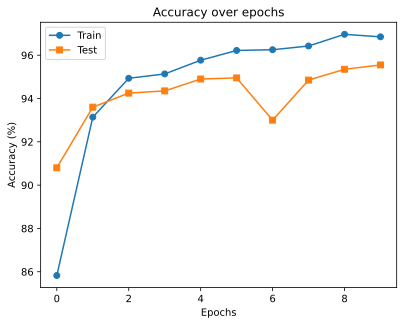

In [23]:
ANN_base, lossFunction, optimizer = getModel()

trainAcc_base, testAcc_base, losses_base, ANN_base = trainModel(ANN_base, lossFunction, optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## Set all the weights for h1 to zero

In [25]:
ANN_h1_zero, lossFunction, optimizer = getModel()

ANN_h1_zero.h1.weight.data = torch.zeros_like(ANN_h1_zero.h1.weight)

ANN_h1_zero.h1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [26]:
trainAcc_h1_zero, testAcc_h1_zero, losses_h1_zero, ANN_h1_zero = trainModel(ANN_h1_zero, lossFunction, optimizer)

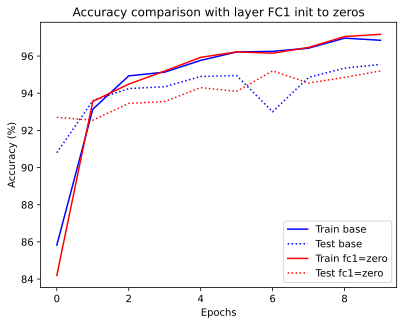

In [27]:
plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_h1_zero)),trainAcc_h1_zero,'r-', range(len(testAcc_h1_zero)),testAcc_h1_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

#### Setting only h1 weights to 0 doesn't have much impact

tensor([[-0.1818,  0.3478, -0.0364,  ..., -0.7912,  0.4718,  0.3076],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3792, -0.3873, -0.4582,  ...,  0.2553,  0.6511, -0.9230],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3517,  0.0525, -0.5148,  ...,  0.4889, -0.7216,  0.1682],
        [-0.6842, -0.1220, -0.8285,  ..., -0.9475, -0.4057,  0.0447]])


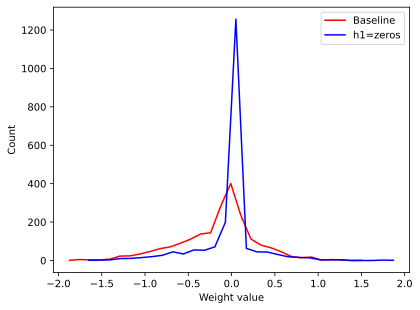

In [31]:
# Are the weights still zeros?
print(ANN_h1_zero.h1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(ANN_base.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(ANN_h1_zero.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='h1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

## Setting all the weights to 0

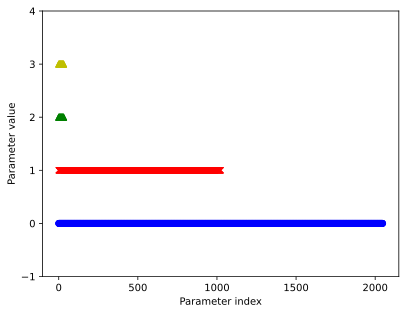

In [38]:
ANN_allzero, lossFunction, optimizer = getModel()

for p in ANN_allzero.named_parameters():
    p[1].data = torch.zeros_like(p[1].data)

# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+ANN_allzero.h1.weight.data.flatten(),'bo')
plt.plot(1+ANN_allzero.h2.weight.data.flatten(),'rx')
plt.plot(2+ANN_allzero.h1.bias.data.flatten(),'g^')
plt.plot(3+ANN_allzero.h2.bias.data.flatten(),'y^')
plt.xlabel('Parameter index')
plt.ylim([-1,4])
plt.ylabel('Parameter value')
plt.show()


In [39]:
trainAcc_allzero, testAcc_allzero, losses_allzero, ANN_allzero = trainModel(ANN_allzero, lossFunction, optimizer)

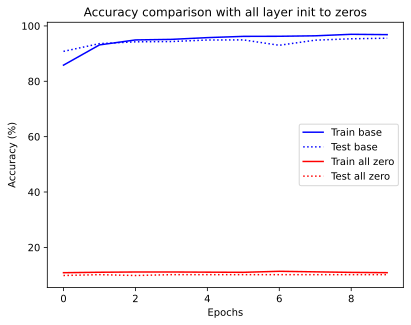

In [40]:
plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layer init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

#### Setting all the weights to zero impacted the model performance

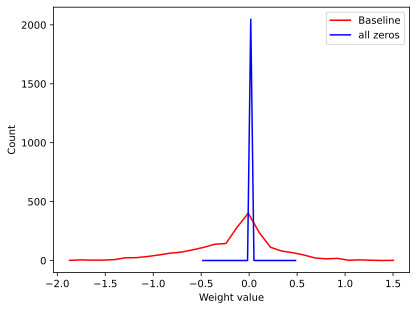

In [51]:
# show the distributions in a histogram
y,x = np.histogram(ANN_base.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(ANN_allzero.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='all zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

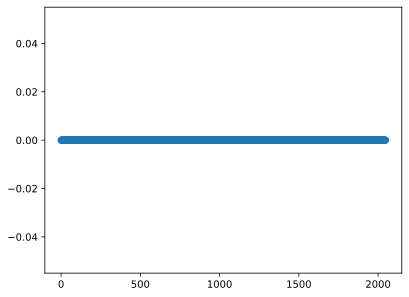

In [43]:
plt.plot(ANN_allzero.h1.weight.data.flatten(),'o')
plt.show()

#### Not even a single weight is non-zero!!!

## Let's try with 1's. Maybe zero is the problem

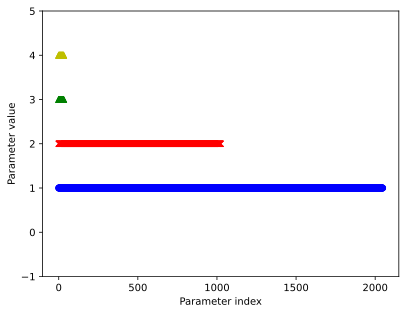

In [46]:
ANN_allone, lossFunction, optimizer = getModel()

for p in ANN_allone.named_parameters():
    p[1].data = torch.zeros_like(p[1].data) + 1

# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+ANN_allone.h1.weight.data.flatten(),'bo')
plt.plot(1+ANN_allone.h2.weight.data.flatten(),'rx')
plt.plot(2+ANN_allone.h1.bias.data.flatten(),'g^')
plt.plot(3+ANN_allone.h2.bias.data.flatten(),'y^')
plt.xlabel('Parameter index')
plt.ylim([-1,5])
plt.ylabel('Parameter value')
plt.show()

In [47]:
trainAcc_allone, testAcc_allone, losses_allone, ANN_allone = trainModel(ANN_allone, lossFunction, optimizer)

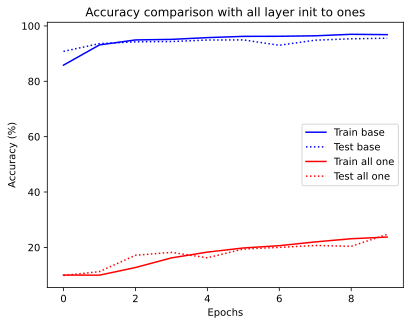

In [48]:
plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all one','Test all one'])
plt.title('Accuracy comparison with all layer init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

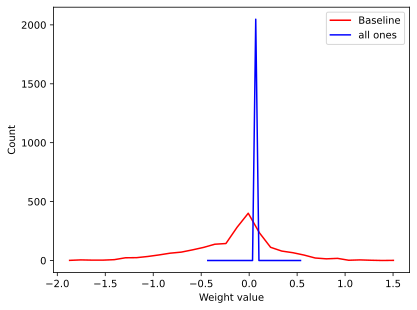

In [50]:
# show the distributions in a histogram
y,x = np.histogram(ANN_base.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(ANN_allone.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='all ones')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

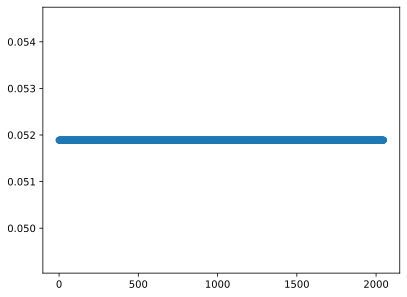

In [52]:
plt.plot(ANN_allone.h1.weight.data.flatten(),'o')
plt.show()

#### Some change here but the model performance is still low